In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random

In [ ]:
def f(x):
  return 3*x**2 - 4*x + 5

In [ ]:
f(3.0)

20.0

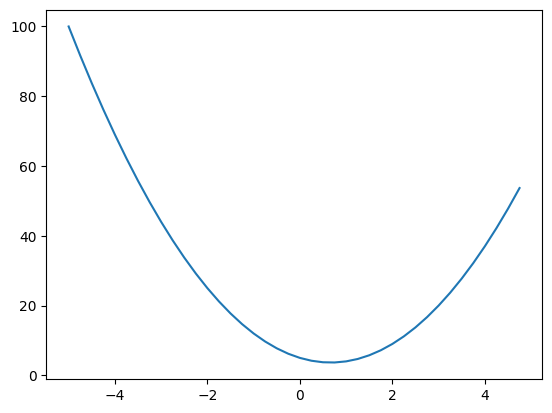

In [ ]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [ ]:
h = 0.000001
x = 2/3
(f(x + h) - f(x))/h

2.999378523327323e-06

In [ ]:
# more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [ ]:
h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0
d = a*b + c

d1 = a*b + c
c += h
d2 = a*b + c

print("slop wrt c: ", (d2 - d1)/h)

slop wrt c:  0.9999999999976694


In [ ]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), "+")

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __radd__(self, other):
    # handles cases like 0 + Value(...) when using sum()
    return self.__add__(other)


  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), "*")

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self, ), f'**{other}')

    def _backward():
      self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other):
    return self * other

  def __truediv__(self, other):
    return self * other**-1

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def tanh(self):
    n = self.data
    t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out

  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [ ]:
from graphviz import Digraph

def trace(root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      dot.node(name = uid + n._op, label = n._op)
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [ ]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights in neurion (strength of each input)
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the model
b = Value(6.8813735870195432, label='b')

# x1w1 + x2w2 + b
w1x1 = w1 * x1; w1x1.label = 'w1x1'
w2x2 = w2 * x2; w2x2.label = 'w2x2'
w1x1w2x2 = w1x1 + w2x2; w1x1w2x2.label = 'w1x1 + w2x2'
n = w1x1w2x2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'
o.backward()

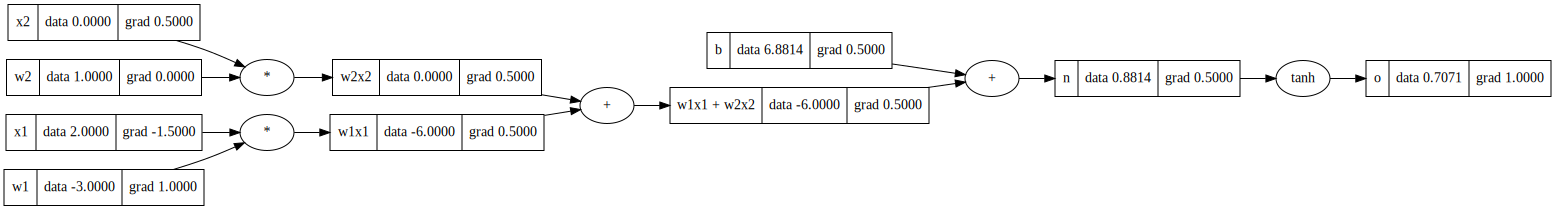

In [ ]:
draw_dot(o)

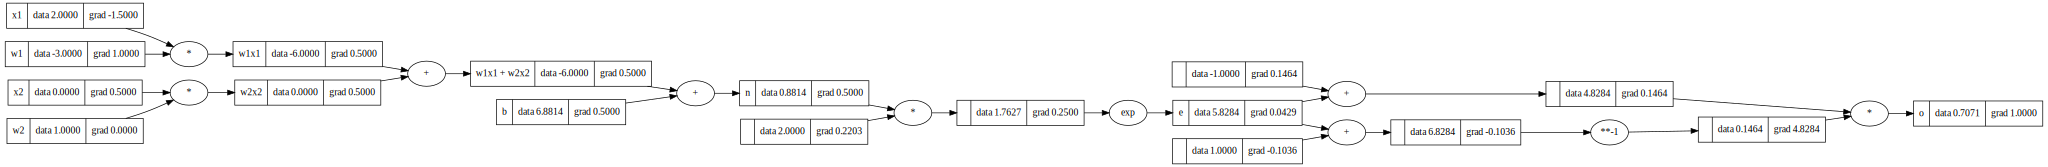

In [ ]:
## Breaking up tanh into multiple differnet operations

# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights in neurion (strength of each input)
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of the model
b = Value(6.8813735870195432, label='b')

# x1w1 + x2w2 + b
w1x1 = w1 * x1; w1x1.label = 'w1x1'
w2x2 = w2 * x2; w2x2.label = 'w2x2'
w1x1w2x2 = w1x1 + w2x2; w1x1w2x2.label = 'w1x1 + w2x2'
n = w1x1w2x2 + b; n.label = 'n'

e = (2*n).exp(); e.label = 'e'
o = (e - 1) / (e + 1); o.label = 'o'

o.backward()
draw_dot(o)

In [ ]:
import torch

# by default tensor are float 32, .double makes the tensor float 64
x1 = torch.Tensor([2.0]).double()                      ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                      ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                     ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                       ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()        ; b.requires_grad = True
n = w1*x1 + w2*x2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("---")
print("x2", x2.grad.item())
print("w2", w2.grad.item())
print("x1", x1.grad.item())
print("w1", w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [ ]:
class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))

  def __call__(self, x):
    # w * x + b, w * x is a dot product of weights and neurons input
    act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  # perameters of neurons
  def parameters(self):
    return self.w + [self.b]

# creates a layer of neurons from Neuron class
class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]

    # for convinence allows us to get a single value of of the last layer
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

# builds a multi-layer percepitron
class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [ ]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.28778992302713396)

In [ ]:
xs = [
      [2.0, 3.0, -1.0],
      [3.0, -1.0, 0.5],
      [0.5, 1.0, 1.0],
      [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]

In [ ]:
for k in range(100):


  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  for p in n.parameters():
    p.data += -0.05 * p.grad
  print(k, loss.data)



0 6.076179101019927
1 3.1066433628243453
2 1.0163336503550817
3 0.4952056568017539
4 0.3112726672264785
5 0.2226529379588548
6 0.17162429607236035
7 0.1387942351477718
8 0.1160401883278051
9 0.09940866575998486
10 0.08675877165620777
11 0.07683554108242427
12 0.06885696467665366
13 0.062311504038618085
14 0.05685106397528929
15 0.052230881409660534
16 0.048274032252898766
17 0.044849575606034364
18 0.04185860583959324
19 0.03922507292832156
20 0.036889576739302876
21 0.03480507174191212
22 0.032933831290601935
23 0.031245261776981073
24 0.02971430218359204
25 0.02832023443540302
26 0.027045786910386456
27 0.025876450379715275
28 0.024799950041711302
29 0.023805833729993436
30 0.022885147608608176
31 0.022030178470198895
32 0.021234247250992242
33 0.020491542300398537
34 0.01979698377779173
35 0.01914611262001459
36 0.018534999052064675
37 0.0179601667532445
38 0.017418529648654396
39 0.01690733894673291
40 0.01642413854148548
41 0.01596672728192488
42 0.015533126909345028
43 0.01512155

In [ ]:
ypred

[Value(data=0.9779640850380369),
 Value(data=-0.9616098539666315),
 Value(data=-0.9552530667189139),
 Value(data=0.9555781101426197)]